The goal of this notebook is to check the performance of various formulations

In [1]:
using Pkg; Pkg.activate()
using Runner, Zoo, Serialization, nGraph, JuMP, Plots

┌ Info: Recompiling stale cache file /home/mark/.julia/compiled/v1.1/Runner/F5BZU.ji for Runner [4a6e9825-ed04-540b-82d3-f33d0e8d45fb]
└ @ Base loading.jl:1184


false

In [ ]:
f = () -> Zoo.resnet_training(200, 256)
nsteps = 5

# Generator functions for the various optimization methods
simple(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    return Runner.Simple(x)
end

synchronous(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    return Runner.Synchronous(x, 29000, 12000)
end

# Fractions of the dram limit to use
r = exp10.(range(0, 1; length = nsteps))
r = r .- minimum(r)
fractions = r ./ maximum(r)

simple_iter = simple.(fractions)
synchronous_iter = synchronous.(fractions)

simple_data = Runner.compare(f, simple_iter; statspath = "serials/resnet200_256_simple.jls")
synchronous_data = Runner.compare(f, synchronous_iter; statspath = "serials/resnet200_256_synchronous.jls")

Processing 1 of 3


sizes_mb = [0, 32612, 65224, 97836, 130448]
(compare_data.simple).actual_runtimes ./ 1.0e6 = [0.000179857, 5.78434e-5, 4.56796e-5, 3.83773e-5, 3.33272e-5]


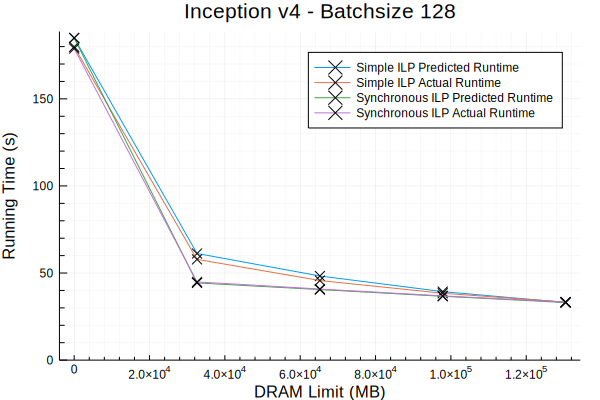

In [2]:
#compare_data = deserialize("inception_v4_128_compare.jls")
compare_data = deserialize("resnet_200_512_compare.jls")
sizes_mb = compare_data.simple.dram_limits

@show sizes_mb
@show compare_data.simple.actual_runtimes ./ 1e6

plot(
    sizes_mb,
    compare_data.simple.predicted_runtimes ./ 1e6,
    marker = :x,
    label = "Simple ILP Predicted Runtime",
    minorgrid = true,
)
plot!(
    sizes_mb,
    compare_data.simple.actual_runtimes,
    marker = :x,
    label = "Simple ILP Actual Runtime"
)
plot!(
    sizes_mb,
    compare_data.synchronous.predicted_runtimes ./ 1e6,
    marker = :x,
    label = "Synchronous ILP Predicted Runtime"
)
plot!(
    sizes_mb,
    compare_data.synchronous.actual_runtimes,
    marker = :x,
    label = "Synchronous ILP Actual Runtime"
)

title!("Inception v4 - Batchsize 128")
ylabel!("Running Time (s)")
xlabel!("DRAM Limit (MB)")
yaxis!((0, 1.02 * maximum(compare_data.simple.predicted_runtimes ./ 1e6)))